In [2]:
import os
import re
import warnings

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import KFold, GroupKFold, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge, Lasso

from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from dataclasses import dataclass, field
from typing import List, Optional, Dict, Tuple

# GroupKFold for device/driver holdout cross-validation
# PowerTransformer for feature scaling

In [3]:
train = pd.read_csv('data/raw/public_train.csv')
test = pd.read_csv('data/raw/public_test.csv')

In [7]:
processed_tr = pd.read_csv('/home/lazar-suciu/Documents/semester3/gt_lab/hw/nagyhazi/data/processed/df_model_final.csv')
processed_tr.columns
processed_te = pd.read_csv('/home/lazar-suciu/Documents/semester3/gt_lab/hw/nagyhazi/data/processed/df_test_final.csv')
processed_te.columns

Index(['ID', 'engine_percent_load_at_current_speed_mean', 'duration_sum',
       'load_x_speed', 'speed_mean', 'engine_speed_mean', 'speed_firstInTrip',
       'vehicle_prod_year', 'accelerator_pedal_position_mean',
       'TE__vehicle_type', 'weight_2', 'brake_switch_mean',
       'engine_coolant_temperature_mean', 'speed_lastintrip',
       'speed_delta_last_first', 'distance_4', 'distance_3',
       'speed_ratio_mean_first', 'weight_2_isna', 'loc_pca_2', 'loc_pca_4',
       'cruise_control_active_mean', 'weight_1', 'TE__driver_name_and_id',
       'load_x_temp', 'env_wind_kph', 'env_precip_1hr_metric', 'wind_x_speed',
       'weekday_cos', 'hour_sin', 'weekday_sin', 'hour_cos', 'loc_pca_3',
       'ambient_air_temperature_mean', 'heading_mean', 'humidity_x_speed',
       'ID.1', 'loc_pca_1', 'heading_diff_std', 'env_temp_c'],
      dtype='object')

In [8]:
# drop sin, cos features, save
processed_tr = processed_tr.loc[:, ~processed_tr.columns.str.contains('sin|cos')]
processed_tr.to_csv('/home/lazar-suciu/Documents/semester3/gt_lab/hw/nagyhazi/data/processed/df_model_final_nosincos.csv', index=False)
processed_te = processed_te.loc[:, ~processed_te.columns.str.contains('sin|cos')]
processed_te.to_csv('/home/lazar-suciu/Documents/semester3/gt_lab/hw/nagyhazi/data/processed/df_model_final_test_nosincos.csv', index=False)

In [3]:
train.dtypes

ID                        int64
deviceuniquecode          int64
Trip_ID_first             int64
Trip_ID_last            float64
fuel_consumption_sum    float64
                         ...   
location_8              float64
distance_1              float64
distance_2              float64
distance_3              float64
distance_4              float64
Length: 62, dtype: object

In [ ]:
categorical_features = [
        'ID',
        'deviceuniquecode',
        'road_level_approximation',
        'driver_name_and_id',
        'Trip_ID_first',
        'Trip_ID_last',
        'vehicle_type',
        'vehicle_type_1',
        'vehicle_type_2',
        'vehicle_type_3',
        'vehicle_type_4',
        'vehicle_type_5',
        'vehicle_type_6',
        'vehicle_motortype',
    ]

train_numerical_features = [col for col in train.columns if col not in categorical_features]
test_numerical_features = [col for col in test.columns if col not in categorical_features]

drop_cols = [
        'env_observation_location_elevat', 
        'ID',
        'road_level_approximation', # drop because too lazy :)
        'Trip_ID_first',
        'Trip_ID_last',
        'vehicle_motortype',
        'vehicle_type_1',
        'vehicle_type_2',
        'vehicle_type_3',
        'vehicle_type_4',
        'vehicle_type_5',
        'vehicle_type_6',
    ]

In [4]:
fixed_order = ['ID', 'deviceuniquecode', 'Trip_ID_first', 'Trip_ID_last',
       'duration_sum', 'speed_firstInTrip',
       'speed_lastintrip', 'speed_mean', 'heading_diff_std', 'heading_mean',
       'ambient_air_temperature_mean', 'brake_switch_mean',
       'cruise_control_active_mean', 'accelerator_pedal_position_mean',
       'engine_percent_load_at_current_speed_mean', 'engine_speed_mean',
       'engine_coolant_temperature_mean', 'road_level_approximation',
       'driver_name_and_id', 'vehicle_type', 'vehicle_prod_year',
       'vehicle_motortype', 'env_observation_location_elevat',
       'env_precip_1hr_metric', 'env_precip_today_metric',
       'env_relative_humidity', 'env_temp_c', 'env_visibility_km',
       'env_wind_degrees', 'env_wind_gust_kph', 'env_wind_kph',
       'env_wind_degrees_based_on_vehicle_direction', 'env_sailing_value',
       'speed_diff', 'speed_trend', 'weight_1', 'weight_2',
       'vehicle_type_1', 'vehicle_type_2', 'vehicle_type_3', 'vehicle_type_4',
       'vehicle_type_5', 'vehicle_type_6', 'Hour', 'Minute', 'Weekday',
       'location_0', 'location_1', 'location_2', 'location_3', 'location_4',
       'location_5', 'location_6', 'location_7', 'location_8', 'location_9', 'location_10', 'distance_1',
       'distance_2', 'distance_3', 'distance_4', 'fuel_consumption_sum']

train = train[fixed_order]
test = test[fixed_order[:len(fixed_order)-1]]

In [ ]:
# Analyze NaN values and save to CSV
for name, df in [('train', train), ('test', test)]:
    nan_info = {}
    for col in df.columns:
        nan_count = df[col].isna().sum()
        nan_percentage = (nan_count / len(df)) * 100
        nan_info[col] = {'column_name': col, 'nan_count': nan_count, 'nan_percentage': nan_percentage}

    nan_info = pd.DataFrame.from_dict(nan_info, orient='index').sort_values('nan_count', ascending=False)
    os.makedirs('data', exist_ok=True)
    nan_info.to_csv(f'data/{name}_nan_info.csv')


## Data Cleaning

engine load mean negative
env relative humid -999
gyanusan sok 0 es 10km lathatosag
gyanusan sok 0 fok szelirany
gyanusan sok 0 kmh wind gust es wind, 0-1 kozott nem mer
gyanusan sok 0 env_wind_degrees_based_on_vehicle_direction
sok 0 sailing value
only 1 vehicle motor type
2 weight_2 values
what are locations, distances, weight2?

In [6]:
# copilot generated function to compute numerical outliers
def compute_numerical_outliers(df, df_name="dataframe", cols=None, quantiles=(0.01, 0.99),
                               iqr_multiples=(1.5, 3.0), mean_std_mult=3, save = True, save_dir="data"):
    """
    For each numeric column in `cols` (or all numeric columns if None) compute:
      - Q1, Q3, IQR
      - lower/upper thresholds by IQR rule (1.5 and 3.0 multiples)
      - mean +/- mean_std_mult * std
      - low/high quantiles (default 1% and 99%)
      - counts and % of values below each lower threshold and above each upper threshold
    Save results to {save_dir}/{df_name}_numerical_outliers.csv and return the summary DataFrame.
    Percentages are computed relative to non-missing values per column.
    """
    if save:
        os.makedirs(save_dir, exist_ok=True)
    if cols is None:
        cols = df.select_dtypes(include=[np.number]).columns.tolist()
    # allow single column string
    if isinstance(cols, str):
        cols = [cols]
    rows = []
    for col in cols:
        s = df[col].dropna()
        n_total = len(df)
        n_nonnull = s.size
        if n_nonnull == 0:
            # no data -> fill NaNs
            row = {
                "feature": col, "n_total": n_total, "n_nonnull": 0
            }
            rows.append(row)
            continue
        q1 = s.quantile(0.25)
        q3 = s.quantile(0.75)
        iqr = q3 - q1
        th_iqr_lo = q1 - iqr * iqr_multiples[0]
        th_iqr_hi = q3 + iqr * iqr_multiples[0]
        th_iqr_lo_strict = q1 - iqr * iqr_multiples[1]
        th_iqr_hi_strict = q3 + iqr * iqr_multiples[1]
        mean = s.mean()
        std = s.std()
        th_mean_lo = mean - mean_std_mult * std
        th_mean_hi = mean + mean_std_mult * std
        q_low = s.quantile(quantiles[0])
        q_high = s.quantile(quantiles[1])

        # counts (relative to non-null values)
        def pct(count):
            return 100.0 * count / n_nonnull if n_nonnull else np.nan

        cnt_iqr_lo = (s < th_iqr_lo).sum()
        cnt_iqr_hi = (s > th_iqr_hi).sum()
        cnt_iqr_lo_strict = (s < th_iqr_lo_strict).sum()
        cnt_iqr_hi_strict = (s > th_iqr_hi_strict).sum()
        cnt_mean_lo = (s < th_mean_lo).sum()
        cnt_mean_hi = (s > th_mean_hi).sum()
        cnt_q_low = (s < q_low).sum()
        cnt_q_high = (s > q_high).sum()

        row = {
            "feature": col,
            "n_total": n_total,
            "n_nonnull": n_nonnull,
            "q1": q1, "q3": q3, "iqr": iqr,
            f"th_iqr_lo_{iqr_multiples[0]}": th_iqr_lo,
            f"th_iqr_hi_{iqr_multiples[0]}": th_iqr_hi,
            f"th_iqr_lo_{iqr_multiples[1]}": th_iqr_lo_strict,
            f"th_iqr_hi_{iqr_multiples[1]}": th_iqr_hi_strict,
            "th_mean_lo": th_mean_lo,
            "th_mean_hi": th_mean_hi,
            f"q_{quantiles[0]}": q_low,
            f"q_{quantiles[1]}": q_high,
            "cnt_iqr_lo": int(cnt_iqr_lo),
            "pct_iqr_lo": pct(cnt_iqr_lo),
            "cnt_iqr_hi": int(cnt_iqr_hi),
            "pct_iqr_hi": pct(cnt_iqr_hi),
            "cnt_iqr_lo_strict": int(cnt_iqr_lo_strict),
            "pct_iqr_lo_strict": pct(cnt_iqr_lo_strict),
            "cnt_iqr_hi_strict": int(cnt_iqr_hi_strict),
            "pct_iqr_hi_strict": pct(cnt_iqr_hi_strict),
            "cnt_mean_lo": int(cnt_mean_lo),
            "pct_mean_lo": pct(cnt_mean_lo),
            "cnt_mean_hi": int(cnt_mean_hi),
            "pct_mean_hi": pct(cnt_mean_hi),
            f"cnt_q_{quantiles[0]}": int(cnt_q_low),
            f"pct_q_{quantiles[0]}": pct(cnt_q_low),
            f"cnt_q_{quantiles[1]}": int(cnt_q_high),
            f"pct_q_{quantiles[1]}": pct(cnt_q_high),
        }
        rows.append(row)

    out = pd.DataFrame(rows).set_index("feature")
    if save:
        out_filepath = os.path.join(save_dir, f"{df_name}_numerical_outliers.csv")
        out.to_csv(out_filepath)
        print(f"Saved outlier summary to {out_filepath} ({len(out)} features)")
    return out

In [7]:
# copilot generated function to visualize outlier thresholds
def visualize_outlier_thresholds(out_df, df, features=None, bins=80):
    """
    Visualize distributions and outlier thresholds.
    - out_df: DataFrame returned by compute_numerical_outliers (indexed by feature)
    - df: original DataFrame containing the raw columns
    - features: list of features to plot (defaults to all features in out_df)
    - save_dir: directory to save PNGs
    - bins: histogram bins
    - show: if True display the plot (useful in notebook)
    """
    import matplotlib.pyplot as plt

    if features is None:
        features = list(out_df.index)

    for feat in features:
        if feat not in df.columns:
            print(f"skip {feat}: not in dataframe")
            continue
        s = df[feat].dropna()
        if s.empty:
            print(f"skip {feat}: no non-null values")
            continue

        # collect threshold columns available in out_df
        row = out_df.loc[feat]
        th_lines = []
        # iqr-based thresholds (any matching column)
        for col in out_df.columns:
            if col.startswith('th_iqr_hi_') or col.startswith('th_iqr_lo_'):
                th_lines.append((col, row.get(col, np.nan)))
        # mean-based
        if 'th_mean_hi' in out_df.columns:
            th_lines.append(('th_mean_hi', row.get('th_mean_hi', np.nan)))
        if 'th_mean_lo' in out_df.columns:
            th_lines.append(('th_mean_lo', row.get('th_mean_lo', np.nan)))
        # quantile thresholds (q_0.01 / q_0.99 etc.)
        for col in out_df.columns:
            if col.startswith('q_'):
                th_lines.append((col, row.get(col, np.nan)))

        # sort by value (optional)
        th_lines = [(label, float(val)) for label, val in th_lines if (val is not None and not pd.isna(val))]
        th_lines = sorted(th_lines, key=lambda x: x[1])

        # plot
        plt.figure(figsize=(9,4))
        sns.histplot(s, bins=bins, kde=True, color='C0')
        colors = ['r','m','g','y','c','k']
        for i, (label, val) in enumerate(th_lines):
            plt.axvline(val, color=colors[i % len(colors)], linestyle='--', lw=2, label=f'{label}: {val:.3f}')
        plt.xlabel(feat)
        plt.title(f'{feat} — distribution and thresholds')
        plt.legend(loc='best', fontsize='small')
        plt.tight_layout()

        plt.show()
        plt.close()

        # print concise counts from out_df if present
        def getcnt(k): 
            return (int(row[k]) if k in row and not pd.isna(row[k]) else None)
        info_keys = ['cnt_iqr_hi','pct_iqr_hi','cnt_iqr_hi_strict','pct_iqr_hi_strict',
                     'cnt_mean_hi','pct_mean_hi', 'cnt_q_0.99','pct_q_0.99']
        info = {k: row.get(k, None) for k in info_keys if k in out_df.columns}
        if info:
            print(f"{feat} summary (from out_df):", {k: (float(v) if not pd.isna(v) else None) for k,v in info.items()})


In [8]:
train_cleaned = train.copy()
test_cleaned = test.copy()
# train + test for means
train_test = pd.concat([train, test], axis=0, ignore_index=True)

# replace negative engine load values with 0
train_cleaned['engine_percent_load_at_current_speed_mean'] = train_cleaned['engine_percent_load_at_current_speed_mean'].apply(lambda x: 0 if x < 0 else x)
test_cleaned['engine_percent_load_at_current_speed_mean'] = test_cleaned['engine_percent_load_at_current_speed_mean'].apply(lambda x: 0 if x < 0 else x)

# handle sentinel value -999 in env_relative_humidity by replacing with mean of non-sentinel values
mean_humidity = train_test.loc[train_test['env_relative_humidity'] != -999, 'env_relative_humidity'].mean()
train_cleaned['env_relative_humidity'].replace(-999, mean_humidity, inplace=True)
test_cleaned['env_relative_humidity'].replace(-999, mean_humidity, inplace=True)

# handle outliers in ambient_air_temperature_mean by capping values above strict IQR threshold to mean of non-outlier values
outliers = compute_numerical_outliers(train_cleaned, df_name="train", cols=['ambient_air_temperature_mean'], save = False)
threshold_iqr_strict = outliers.loc['ambient_air_temperature_mean', 'th_iqr_hi_3.0']
mean_ambient_air_temperature = train_test.loc[train_test['ambient_air_temperature_mean'] <= threshold_iqr_strict, 'ambient_air_temperature_mean'].mean()
train_cleaned['ambient_air_temperature_mean'] = train_cleaned['ambient_air_temperature_mean'].apply(lambda x: mean_ambient_air_temperature if x > threshold_iqr_strict else x)
test_cleaned['ambient_air_temperature_mean'] = test_cleaned['ambient_air_temperature_mean'].apply(lambda x: mean_ambient_air_temperature if x > threshold_iqr_strict else x)

/tmp/ipykernel_4511/3745094422.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_cleaned['env_relative_humidity'].replace(-999, mean_humidity, inplace=True)
/tmp/ipykernel_4511/3745094422.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col]

Saved outlier summary to data/train_numerical_outliers.csv (3 features)


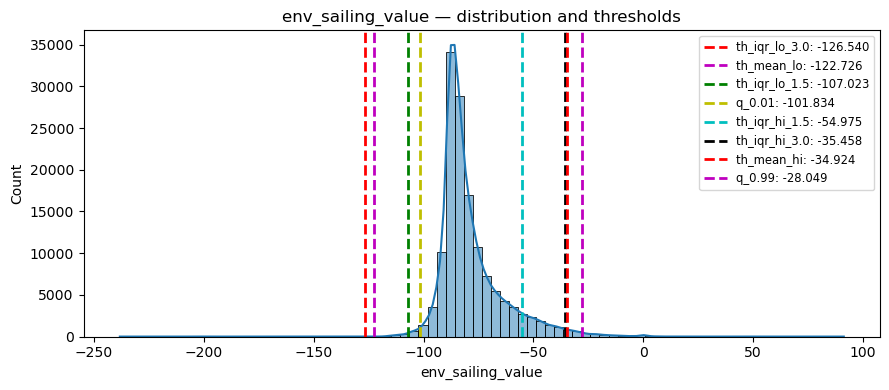

env_sailing_value summary (from out_df): {'cnt_iqr_hi': 10839.0, 'pct_iqr_hi': 7.75355165457745, 'cnt_iqr_hi_strict': 2645.0, 'pct_iqr_hi_strict': 1.8920697597894045, 'cnt_mean_hi': 2508.0, 'pct_mean_hi': 1.7940684149534314, 'cnt_q_0.99': 1398.0, 'pct_q_0.99': 1.0000429202970085}


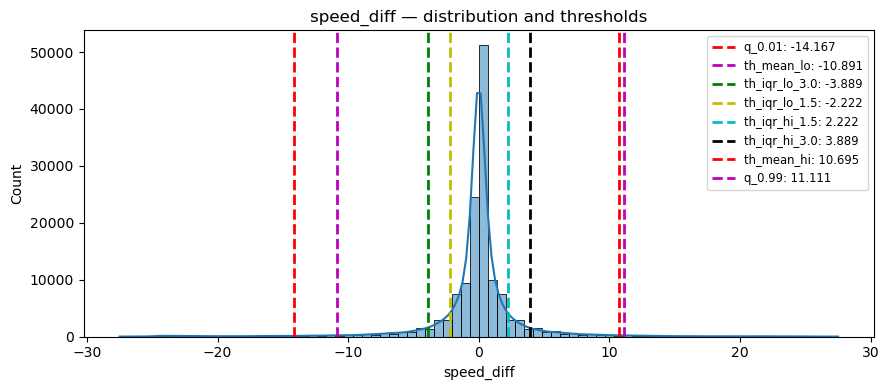

speed_diff summary (from out_df): {'cnt_iqr_hi': 12740.0, 'pct_iqr_hi': 9.113409731462008, 'cnt_iqr_hi_strict': 7205.0, 'pct_iqr_hi_strict': 5.154012332432007, 'cnt_mean_hi': 1547.0, 'pct_mean_hi': 1.1066283245346724, 'cnt_q_0.99': 1398.0, 'pct_q_0.99': 1.0000429202970085}


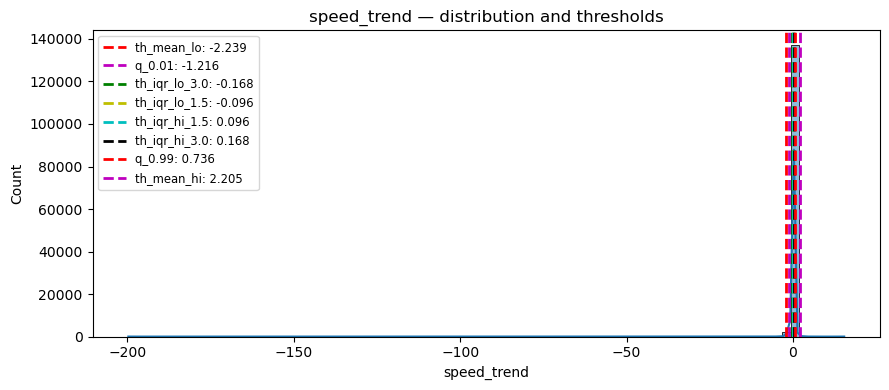

speed_trend summary (from out_df): {'cnt_iqr_hi': 14738.0, 'pct_iqr_hi': 10.54265562184357, 'cnt_iqr_hi_strict': 9236.0, 'pct_iqr_hi_strict': 6.606864386168219, 'cnt_mean_hi': 135.0, 'pct_mean_hi': 0.09657066826902443, 'cnt_q_0.99': 1398.0, 'pct_q_0.99': 1.0000429202970085}


In [9]:
# approx. 20% missing value features
missing_value_features = ['env_sailing_value','speed_diff', 'speed_trend']
outliers = compute_numerical_outliers(train, df_name="train", cols=missing_value_features, save_dir="data", save= True)
visualize_outlier_thresholds(outliers, train, features=missing_value_features, bins=80)

In [10]:
# for speed trend cut below th_mean_lo, replace with mean of non-outlier values
th_mean_lo = outliers.loc['speed_trend', 'th_mean_lo']
mean_speed_trend = train_test.loc[train_test['speed_trend'] >= th_mean_lo, 'speed_trend'].mean()
train_cleaned['speed_trend'] = train_cleaned['speed_trend'].apply(lambda x: mean_speed_trend if x < th_mean_lo else x)
test_cleaned['speed_trend'] = test_cleaned['speed_trend'].apply(lambda x: mean_speed_trend if x < th_mean_lo else x)

# Feature Engineering

In [ ]:
# copilot generated function to impute missing values with best method per feature
def impute_best_per_feature(df, features, rf_target, numeric_cols=None, group_col='vehicle_type',
                            methods=None, verbose=False):
    """
    For each feature in `features` try multiple imputation methods, evaluate downstream
    performance (RF predicting `rf_target`) and keep the best method.
    Returns (df_out, summary_df) where df_out has chosen imputations applied and
    summary_df lists chosen method + RMSE per feature.
    - df : DataFrame (will not be modified in-place; a copy is returned)
    - features : list of columns to impute
    - rf_target : column name of downstream target (must exist in df)
    - numeric_cols : list of numeric columns to use as model predictors (defaults to df.select_dtypes)
    - group_col : column used for group-wise median imputation (if present)
    - methods : list of methods to try: subset of ['mean','median','group_median','knn','iterative','predictive']
    """
    if methods is None:
        methods = ['median', 'mean', 'group_median', 'knn', 'iterative', 'predictive']

    df_work = df.copy()
    if numeric_cols is None:
        numeric_cols = df_work.select_dtypes(include=[np.number]).columns.tolist()
    # ensure rf_target is present in numeric_cols for modeling label, remove from predictors
    predictors = [c for c in numeric_cols if c != rf_target]

    summary = []
    for feat in features:
        if feat not in df_work.columns:
            if verbose: print(f"skip {feat}: not in dataframe")
            continue
        if df_work[feat].notna().all():
            if verbose: print(f"skip {feat}: no missing")
            summary.append({'feature': feat, 'chosen_method': None, 'rmse': None})
            continue

        results = {}
        for m in methods:
            tmp = df_work.copy()
            try:
                if m == 'mean':
                    tmp[feat] = tmp[feat].fillna(tmp[feat].mean())
                elif m == 'median':
                    tmp[feat] = tmp[feat].fillna(tmp[feat].median())
                elif m == 'group_median':
                    if group_col in tmp.columns:
                        tmp[feat] = tmp.groupby(group_col)[feat].apply(lambda s: s.fillna(s.median()))
                        # fallback global median for any remaining
                        tmp[feat] = tmp[feat].fillna(tmp[feat].median())
                    else:
                        tmp[feat] = tmp[feat].fillna(tmp[feat].median())
                elif m == 'knn':
                    imputer = KNNImputer(n_neighbors=5)
                    num_sub = tmp[predictors + [feat]].copy()
                    num_filled = imputer.fit_transform(num_sub)
                    tmp.loc[:, predictors + [feat]] = pd.DataFrame(num_filled, columns=predictors + [feat], index=tmp.index)
                elif m == 'iterative':
                    imp = IterativeImputer(random_state=0, max_iter=10)
                    num_sub = tmp[predictors + [feat]].copy()
                    num_filled = imp.fit_transform(num_sub)
                    tmp.loc[:, predictors + [feat]] = pd.DataFrame(num_filled, columns=predictors + [feat], index=tmp.index)
                elif m == 'predictive':
                    # train RF to predict feat using other predictors (simple predictive imputation)
                    train_mask = tmp[feat].notna()
                    pred_cols = [c for c in predictors if c != feat]
                    if len(pred_cols) == 0:
                        raise ValueError("no predictors for predictive imputation")
                    X_tr = tmp.loc[train_mask, pred_cols].fillna(tmp[pred_cols].median())
                    y_tr = tmp.loc[train_mask, feat]
                    rf = RandomForestRegressor(n_estimators=100, random_state=0, n_jobs=-1)
                    rf.fit(X_tr, y_tr)
                    miss_mask = tmp[feat].isna()
                    if miss_mask.any():
                        X_pred = tmp.loc[miss_mask, pred_cols].fillna(tmp[pred_cols].median())
                        tmp.loc[miss_mask, feat] = rf.predict(X_pred)
                else:
                    continue
            except Exception as e:
                if verbose: print(f"method {m} failed for {feat}: {e}")
                continue

            # prepare X/y to evaluate downstream rf_target prediction
            eval_df = tmp.copy()
            eval_mask = eval_df[rf_target].notna()
            if eval_mask.sum() < 30:
                # too few rows to evaluate reliably
                if verbose: print(f"{feat} + {m}: too few rows for evaluation ({eval_mask.sum()})")
                continue

            X = eval_df.loc[eval_mask, predictors].copy()
            # ensure the imputed feature is included in predictors if present
            if feat not in X.columns and feat in eval_df.columns:
                X[feat] = eval_df.loc[eval_mask, feat]
            # fill remaining NA in predictors with median to allow modeling
            X = X.fillna(X.median())
            y = eval_df.loc[eval_mask, rf_target]
            rmse = rf_cv_rmse(X, y)
            results[m] = rmse
            if verbose: print(f"{feat} | {m} -> rmse {rmse:.4f}")

        if not results:
            summary.append({'feature': feat, 'chosen_method': None, 'rmse': None})
            if verbose: print(f"No successful imputation methods for {feat}")
            continue

        # choose best method (lowest rmse)
        best_method = min(results, key=results.get)
        best_rmse = results[best_method]

        # apply chosen method to df_work (persist)
        if verbose: print(f"{feat}: chosen {best_method} (rmse={best_rmse:.4f})")
        # apply same imputation again to df_work
        if best_method == 'mean':
            df_work[feat] = df_work[feat].fillna(df_work[feat].mean())
        elif best_method == 'median':
            df_work[feat] = df_work[feat].fillna(df_work[feat].median())
        elif best_method == 'group_median':
            if group_col in df_work.columns:
                df_work[feat] = df_work.groupby(group_col)[feat].apply(lambda s: s.fillna(s.median()))
                df_work[feat] = df_work[feat].fillna(df_work[feat].median())
            else:
                df_work[feat] = df_work[feat].fillna(df_work[feat].median())
        elif best_method == 'knn':
            imputer = KNNImputer(n_neighbors=5)
            cols_k = predictors + [feat]
            num_sub = df_work[cols_k].copy()
            num_filled = imputer.fit_transform(num_sub)
            df_work.loc[:, cols_k] = pd.DataFrame(num_filled, columns=cols_k, index=df_work.index)
        elif best_method == 'iterative':
            imp = IterativeImputer(random_state=0, max_iter=10)
            cols_k = predictors + [feat]
            num_sub = df_work[cols_k].copy()
            num_filled = imp.fit_transform(num_sub)
            df_work.loc[:, cols_k] = pd.DataFrame(num_filled, columns=cols_k, index=df_work.index)
        elif best_method == 'predictive':
            train_mask = df_work[feat].notna()
            pred_cols = [c for c in predictors if c != feat]
            X_tr = df_work.loc[train_mask, pred_cols].fillna(df_work[pred_cols].median())
            y_tr = df_work.loc[train_mask, feat]
            rf = RandomForestRegressor(n_estimators=100, random_state=0, n_jobs=-1)
            rf.fit(X_tr, y_tr)
            miss_mask = df_work[feat].isna()
            if miss_mask.any():
                X_pred = df_work.loc[miss_mask, pred_cols].fillna(df_work[pred_cols].median())
                df_work.loc[miss_mask, feat] = rf.predict(X_pred)

        # mark method used
        df_work[f"{feat}_imputed_method"] = best_method
        summary.append({'feature': feat, 'chosen_method': best_method, 'rmse': best_rmse})

    summary_df = pd.DataFrame(summary).set_index('feature')
    return df_work, summary_df

In [ ]:
# impute missing values for selected features with mean imputation for now
# for feature in missing_value_features:
#     mean_value = train_test[feature].mean()

#     train[feature].fillna(mean_value, inplace=True)
#     test[feature].fillna(mean_value, inplace=True)
    
#     train_cleaned[feature].fillna(mean_value, inplace=True)
#     test_cleaned[feature].fillna(mean_value, inplace=True)

In [ ]:
# Sin-Cos encoding for temporal features
for col, period in [("Hour", 24), ("Minute", 60), ("Weekday", 7)]:
    df[f"{col.lower()}_sin"] = np.sin(2 * np.pi * df[col] / period)
    df[f"{col.lower()}_cos"] = np.cos(2 * np.pi * df[col] / period)

df = df.drop(columns=["Hour", "Minute", "Weekday"])

In [ ]:
# Optional dependencies
try:
    from xgboost import XGBRegressor
except Exception:
    XGBRegressor = None

try:
    from catboost import CatBoostRegressor
except Exception:
    CatBoostRegressor = None

try:
    import shap
except Exception:
    shap = None


# ---------- basic helpers ----------

def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))


# ---------- OOF target encoding with smoothing (for categorical cols) ----------

def oof_target_encode(
    df: pd.DataFrame,
    target_col: str,
    cat_cols: List[str],
    n_splits: int = 5,
    groups: Optional[pd.Series] = None,
    smoothing_k: float = 10.0,
    global_prior: Optional[float] = None,
    random_state: int = 42,
) -> Tuple[pd.DataFrame, Dict[str, Dict]]:
    """
    Fold-safe target encoding with smoothing.
    Encoded columns are named TE__<col>. Original categorical columns are preserved in df
    (you can drop them after this step if you want).
    """
    df = df.copy()
    y = df[target_col]
    if global_prior is None:
        global_prior = float(y.mean())

    # prepare encoded columns
    for col in cat_cols:
        df[f"TE__{col}"] = np.nan

    # CV splitter
    if groups is not None:
        splitter = GroupKFold(n_splits=n_splits)
        split_iter = splitter.split(df, y, groups=groups)
    else:
        splitter = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
        split_iter = splitter.split(df, y)

    meta: Dict[str, Dict] = {}

    # out-of-fold encodings
    for fold, (tr_idx, va_idx) in enumerate(split_iter, 1):
        df_tr, y_tr = df.iloc[tr_idx], y.iloc[tr_idx]
        df_va = df.iloc[va_idx]

        for col in cat_cols:
            stats = (
                df_tr.groupby(col)[target_col]
                .agg(['count', 'mean'])
                .rename(columns={'count': 'n', 'mean': 'mean'})
            )
            stats["enc"] = (stats["n"] * stats["mean"] + smoothing_k * global_prior) / (
                stats["n"] + smoothing_k
            )
            mapping = stats["enc"]

            df.loc[df.index[va_idx], f"TE__{col}"] = (
                df_va[col].map(mapping).fillna(global_prior)
            )

    # store full-data mappings (for later test/inference use if needed)
    for col in cat_cols:
        stats_full = (
            df.groupby(col)[target_col]
            .agg(['count', 'mean'])
            .rename(columns={'count': 'n', 'mean': 'mean'})
        )
        stats_full["enc"] = (stats_full["n"] * stats_full["mean"] + smoothing_k * global_prior) / (
            stats_full["n"] + smoothing_k
        )
        meta[col] = {
            "global_prior": global_prior,
            "mapping": stats_full["enc"].to_dict(),
            "k": smoothing_k,
        }

    return df, meta


# ---------- numeric preprocessing builders ----------

def build_numeric_pipeline(degree: int = 1, scale: bool = True) -> Pipeline:
    """
    Numeric pipeline:
      - Impute missing values with median
      - Optionally scale
      - Optionally add polynomial interaction terms
    """
    steps = [("imputer", SimpleImputer(strategy="median"))]
    if scale:
        steps.append(("scaler", StandardScaler()))
    if degree and degree > 1:
        steps.append(
            ("poly", PolynomialFeatures(degree=degree, interaction_only=True, include_bias=False))
        )
    return Pipeline(steps)


# ---------- CV results container ----------

@dataclass
class CVResults:
    fold_metrics: List[Dict] = field(default_factory=list)
    feature_importances: Dict[str, List[float]] = field(default_factory=dict)
    shap_importances: Dict[str, List[float]] = field(default_factory=dict)

    def add_feature_importances(self, names: List[str], values: np.ndarray):
        for n, v in zip(names, values):
            self.feature_importances.setdefault(n, []).append(float(v))

    def add_shap_importances(self, names: List[str], values: np.ndarray):
        for n, v in zip(names, values):
            self.shap_importances.setdefault(n, []).append(float(v))

    def summary_tables(self) -> Tuple[pd.DataFrame, pd.DataFrame]:
        fi = pd.DataFrame(
            {
                "feature": list(self.feature_importances.keys()),
                "importance_mean": [np.mean(v) for v in self.feature_importances.values()],
                "importance_std": [np.std(v) for v in self.feature_importances.values()],
            }
        ).sort_values("importance_mean", ascending=False)

        si = pd.DataFrame(
            {
                "feature": list(self.shap_importances.keys()),
                "shap_mean_abs": [np.mean(v) for v in self.shap_importances.values()],
                "shap_std_abs": [np.std(v) for v in self.shap_importances.values()],
            }
        ).sort_values("shap_mean_abs", ascending=False)

        return fi, si


# ---------- core CV runner ----------

def run_cv_model(
    df: pd.DataFrame,
    target_col: str,
    feature_cols: List[str],
    model_init: Callable[[], object],
    n_splits: int = 5,
    groups: Optional[pd.Series] = None,
    use_tree_preproc: bool = True,
    degree_for_linear: int = 1,
    compute_shap_vals: bool = True,
    random_state: int = 42,
) -> Tuple[CVResults, pd.DataFrame]:
    """
    Train a single model with CV.
    All features are treated as numeric at this point (cats already target-encoded).
    - Trees: imputer only
    - Linear models: imputer + scaler (+ optional poly interactions)
    """
    df = df.copy()
    y = df[target_col].values
    X = df[feature_cols].copy()

    # Preprocessor
    if use_tree_preproc:
        pre = Pipeline([("imputer", SimpleImputer(strategy="median"))])
    else:
        pre = build_numeric_pipeline(degree=degree_for_linear, scale=True)

    # CV splitter
    if groups is not None:
        splitter = GroupKFold(n_splits=n_splits)
        splits = list(splitter.split(X, y, groups=groups))
    else:
        splitter = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
        splits = list(splitter.split(X, y))

    results = CVResults()
    oof = np.zeros(len(df))
    feat_names = feature_cols

    for fold, (tr_idx, va_idx) in enumerate(splits, 1):
        X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
        y_tr, y_va = y[tr_idx], y[va_idx]

        # fit preprocessing
        pre.fit(X_tr, y_tr)
        X_tr_t = pre.transform(X_tr)
        X_va_t = pre.transform(X_va)

        # init & fit model
        model = model_init()
        if hasattr(model, "random_state"):
            setattr(model, "random_state", random_state)
        model.fit(X_tr_t, y_tr)

        # predict
        y_pred = model.predict(X_va_t)
        oof[va_idx] = y_pred

        # metrics
        results.fold_metrics.append(
            {
                "fold": fold,
                "rmse": rmse(y_va, y_pred),
                "mae": float(mean_absolute_error(y_va, y_pred)),
                "r2": float(r2_score(y_va, y_pred)),
                "n_train": int(len(tr_idx)),
                "n_valid": int(len(va_idx)),
            }
        )

        # feature importance
        fi = None
        if hasattr(model, "feature_importances_"):
            fi = np.asarray(model.feature_importances_, dtype=float)
        elif hasattr(model, "coef_"):
            coefs = model.coef_
            fi = np.abs(coefs) if np.ndim(coefs) == 1 else np.abs(coefs).mean(axis=0)

        if fi is not None and len(fi) == len(feat_names):
            results.add_feature_importances(feat_names, fi)

        # SHAP values (optional, usually only for trees)
        if compute_shap_vals and shap is not None:
            try:
                explainer = shap.Explainer(model.predict, X_tr_t, algorithm="auto")
                shap_vals = explainer(X_va_t).values
                shap_mean_abs = np.abs(shap_vals).mean(axis=0)
                if len(shap_mean_abs) == len(feat_names):
                    results.add_shap_importances(feat_names, shap_mean_abs)
            except Exception:
                pass

    # OOF dataframe (no ID col; using index as key)
    oof_df = pd.DataFrame(
        {
            "row": df.index.values,
            "y_true": y,
            "y_oof": oof,
        }
    )

    return results, oof_df


In [ ]:
def run_all_baselines(
    df: pd.DataFrame,
    target_col: str,
    categorical_cols: List[str],
    models: Optional[List[str]] = None,
    group_col: Optional[str] = None,
    n_splits: int = 5,
    smoothing_k: float = 10.0,
    linear_degree: int = 1,
    compute_shap: bool = True,
    random_state: int = 42,
) -> Dict[str, Dict]:
    """
    High-level baseline runner.
    - You specify categorical_cols explicitly.
    - No ID column is assumed.
    - Categorical columns have no missing values (no imputation for raw cats; they are target-encoded).
    - 'models' selects which models to run, e.g.: ['xgboost', 'catboost', 'ridge', 'lasso'].
    """
    if models is None:
        models = ["xgboost", "catboost", "ridge", "lasso"]

    df = df.copy()

    # group labels (for driver/device holdout etc.)
    groups = df[group_col] if group_col is not None else None

    # all feature columns before encoding (exclude target)
    all_feature_cols = [c for c in df.columns if c != target_col]

    # numeric columns = everything except target + explicitly categorical
    numeric_cols = [c for c in all_feature_cols if c not in categorical_cols]

    # ------------------- OOF Target Encoding for categorical columns -------------------

    if categorical_cols:
        # Only need df with target + cat_cols for encoding step
        df_te_part = df[[target_col] + categorical_cols].copy()
        df_te, te_meta = oof_target_encode(
            df_te_part,
            target_col=target_col,
            cat_cols=categorical_cols,
            n_splits=n_splits,
            groups=groups,
            smoothing_k=smoothing_k,
            global_prior=None,
            random_state=random_state,
        )
        te_cols = [f"TE__{c}" for c in categorical_cols]

        # Drop original categorical columns, add target-encoded ones
        df_model = pd.concat(
            [
                df[[target_col] + numeric_cols].copy(),
                df_te[te_cols],
            ],
            axis=1,
        )
        feature_cols = numeric_cols + te_cols
    else:
        # No categorical columns
        df_model = df[[target_col] + numeric_cols].copy()
        feature_cols = numeric_cols

    results: Dict[str, Dict] = {}

    # ------------------- XGBoost -------------------
    if "xgboost" in models:
        if XGBRegressor is not None:
            def xgb_init():
                return XGBRegressor(
                    n_estimators=600,
                    max_depth=6,
                    learning_rate=0.05,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    reg_alpha=0.0,
                    reg_lambda=1.0,
                    tree_method="hist",
                    random_state=random_state,
                )

            xgb_res, xgb_oof = run_cv_model(
                df=df_model,
                target_col=target_col,
                feature_cols=feature_cols,
                model_init=xgb_init,
                n_splits=n_splits,
                groups=groups,
                use_tree_preproc=True,
                degree_for_linear=1,
                compute_shap_vals=compute_shap,
                random_state=random_state,
            )
            fi_table, shap_table = xgb_res.summary_tables()
            results["xgboost"] = {
                "cv_metrics": xgb_res.fold_metrics,
                "fi": fi_table,
                "shap": shap_table,
                "oof": xgb_oof,
            }
        else:
            results["xgboost"] = {"error": "XGBoost not installed"}

    # ------------------- CatBoost -------------------
    if "catboost" in models:
        if CatBoostRegressor is not None:
            def cat_init():
                return CatBoostRegressor(
                    iterations=1000,
                    depth=6,
                    learning_rate=0.05,
                    loss_function="RMSE",
                    random_seed=random_state,
                    verbose=False,
                )

            cat_res, cat_oof = run_cv_model(
                df=df_model,
                target_col=target_col,
                feature_cols=feature_cols,
                model_init=cat_init,
                n_splits=n_splits,
                groups=groups,
                use_tree_preproc=True,
                degree_for_linear=1,
                compute_shap_vals=compute_shap,
                random_state=random_state,
            )
            fi_table, shap_table = cat_res.summary_tables()
            results["catboost"] = {
                "cv_metrics": cat_res.fold_metrics,
                "fi": fi_table,
                "shap": shap_table,
                "oof": cat_oof,
            }
        else:
            results["catboost"] = {"error": "CatBoost not installed"}

    # ------------------- Ridge -------------------
    if "ridge" in models:
        def ridge_init():
            return Ridge(alpha=1.0, random_state=random_state)

        ridge_res, ridge_oof = run_cv_model(
            df=df_model,
            target_col=target_col,
            feature_cols=feature_cols,
            model_init=ridge_init,
            n_splits=n_splits,
            groups=groups,
            use_tree_preproc=False,     # linear preprocessing: scale + optional poly
            degree_for_linear=linear_degree,
            compute_shap_vals=False,    # SHAP for linear models not needed here
            random_state=random_state,
        )
        fi_table, _ = ridge_res.summary_tables()
        results["ridge"] = {
            "cv_metrics": ridge_res.fold_metrics,
            "fi": fi_table,
            "oof": ridge_oof,
        }

    # ------------------- Lasso -------------------
    if "lasso" in models:
        def lasso_init():
            return Lasso(alpha=0.001, random_state=random_state, max_iter=10000)

        lasso_res, lasso_oof = run_cv_model(
            df=df_model,
            target_col=target_col,
            feature_cols=feature_cols,
            model_init=lasso_init,
            n_splits=n_splits,
            groups=groups,
            use_tree_preproc=False,
            degree_for_linear=linear_degree,
            compute_shap_vals=False,
            random_state=random_state,
        )
        fi_table, _ = lasso_res.summary_tables()
        results["lasso"] = {
            "cv_metrics": lasso_res.fold_metrics,
            "fi": fi_table,
            "oof": lasso_oof,
        }

    # ------------------- Keep/Drop suggestion (only from actually-run models) -------------------
    all_fi_tables = []
    for m in results:
        if isinstance(results[m], dict) and "fi" in results[m]:
            fi = results[m]["fi"]
            # importance_mean is in column index 1
            tmp = fi[["feature", fi.columns[1]]].copy()
            tmp.columns = ["feature", f"{m}_importance"]
            all_fi_tables.append(tmp)

    if all_fi_tables:
        merged = all_fi_tables[0]
        for t in all_fi_tables[1:]:
            merged = merged.merge(t, on="feature", how="outer")
        merged = merged.fillna(0.0)

        imp_cols = [c for c in merged.columns if c.endswith("_importance")]
        for c in imp_cols:
            merged[f"{c}_rank"] = merged[c].rank(ascending=False, method="average")
        rank_cols = [c for c in merged.columns if c.endswith("_rank")]
        merged["avg_rank"] = merged[rank_cols].mean(axis=1)
        merged = merged.sort_values("avg_rank")

        n = len(merged)
        merged["suggestion"] = "keep"
        merged.loc[merged["avg_rank"] > n * 0.75, "suggestion"] = "drop"
        merged.loc[(merged["avg_rank"] > n * 0.5) & (merged["avg_rank"] <= n * 0.75), "suggestion"] = "review"

        results["keep_drop"] = merged

    return results


In [ ]:
import numpy as np
import pandas as pd

# ------------------- CONFIG ------------------- #
target_col = "fuel_consumption_sum"
categorical_cols = ["deviceuniquecode", "driver_name_and_id", "vehicle_type"]
models_to_run = ["xgboost", "catboost", "ridge", "lasso"]  # subset if you like
group_col = "driver_name_and_id"  # or None
n_splits = 5
smoothing_k = 10.0
linear_degree = 1
compute_shap = True
random_state = 42

# correlation threshold for redundancy pruning
corr_threshold = 0.9   # adjust to be stricter/looser

df = train_cleaned.copy()

# ------------------- 1) BASELINE RUN ------------------- #
results_full = run_all_baselines(
    df=df,
    target_col=target_col,
    categorical_cols=categorical_cols,
    models=models_to_run,
    group_col=group_col,
    n_splits=n_splits,
    smoothing_k=smoothing_k,
    linear_degree=linear_degree,
    compute_shap=compute_shap,
    random_state=random_state,
)

keep_drop_full = results_full["keep_drop"].copy()
print("Top 30 features from baseline run (by avg_rank):")
display(keep_drop_full.head(30))

# ------------------- 2) DROP FEATURES WITH suggestion == 'drop' ------------------- #
# These are feature *names* as seen by the model: TE__cat or raw numeric cols.
drop_features_model = keep_drop_full.loc[keep_drop_full["suggestion"] == "drop", "feature"].tolist()

# For correlation analysis we work with KEEP + REVIEW features:
keep_review_features = keep_drop_full.loc[
    keep_drop_full["suggestion"].isin(["keep", "review"]), "feature"
].tolist()

print(f"\nInitial counts: keep={sum(keep_drop_full['suggestion']=='keep')}, "
      f"review={sum(keep_drop_full['suggestion']=='review')}, "
      f"drop={sum(keep_drop_full['suggestion']=='drop')}")

# ------------------- 3) BUILD MODELING DF FOR CORRELATION CHECK ------------------- #
# We replicate the same encoding logic as run_all_baselines, but only for correlation analysis.

all_feature_cols = [c for c in df.columns if c != target_col]
numeric_cols = [c for c in all_feature_cols if c not in categorical_cols]

groups = df[group_col] if group_col is not None else None

# Target encoding on categorical columns (fold-safe)
df_te_input = df[[target_col] + categorical_cols].copy()
df_te_encoded, _ = oof_target_encode(
    df_te_input,
    target_col=target_col,
    cat_cols=categorical_cols,
    n_splits=n_splits,
    groups=groups,
    smoothing_k=smoothing_k,
    global_prior=None,
    random_state=random_state,
)

te_cols = [f"TE__{c}" for c in categorical_cols]

# df_model_for_corr contains numeric + TE__categoricals only (no target)
df_model_for_corr = pd.concat(
    [df[numeric_cols].reset_index(drop=True),
     df_te_encoded[te_cols].reset_index(drop=True)],
    axis=1,
)

# Restrict to only keep+review features that actually exist in this modeling df
features_for_corr = [f for f in keep_review_features if f in df_model_for_corr.columns]

print(f"\nNumber of features considered for correlation-based pruning: {len(features_for_corr)}")

# ------------------- 4) CORRELATION MATRICES & REDUNDANT FEATURE DROPS ------------------- #
corr_pearson = df_model_for_corr[features_for_corr].corr(method="pearson").abs()
corr_spearman = df_model_for_corr[features_for_corr].corr(method="spearman").abs()

# We'll drop, from each highly correlated pair, the feature with WORSE avg_rank (higher value) from keep_drop_full
rank_map = dict(zip(keep_drop_full["feature"], keep_drop_full["avg_rank"]))

extra_drop_features = set()

feat_list = features_for_corr

for i in range(len(feat_list)):
    for j in range(i + 1, len(feat_list)):
        f1, f2 = feat_list[i], feat_list[j]
        r_p = corr_pearson.loc[f1, f2]
        r_s = corr_spearman.loc[f1, f2]
        if (r_p >= corr_threshold) or (r_s >= corr_threshold):
            # choose the one with worse (higher) avg_rank
            r1 = rank_map.get(f1, np.inf)
            r2 = rank_map.get(f2, np.inf)
            drop_f = f1 if r1 > r2 else f2
            extra_drop_features.add(drop_f)

print(f"\nNumber of additional features to drop due to correlation >= {corr_threshold}: "
      f"{len(extra_drop_features)}")

# ------------------- 5) MAP MODEL FEATURE NAMES -> ORIGINAL DF COLUMNS TO DROP ------------------- #
# drop_features_model = from keep/drop suggestions
# extra_drop_features = from correlation pruning
all_drop_model_features = set(drop_features_model) | extra_drop_features

# Map TE__cat back to original categorical col; numeric features map directly.
cols_to_drop_in_df = set()
for f in all_drop_model_features:
    if f.startswith("TE__"):
        orig = f[4:]   # original categorical column
        if orig in categorical_cols:
            cols_to_drop_in_df.add(orig)
    else:
        # raw numeric feature name
        if f in df.columns and f not in (target_col, group_col):
            cols_to_drop_in_df.add(f)

print(f"\nTotal original columns to drop from df: {len(cols_to_drop_in_df)}")
print("Sample columns to drop:", list(cols_to_drop_in_df)[:15])

# ------------------- 6) BUILD PRUNED DF AND RERUN BASELINES ------------------- #
df_pruned = df.drop(columns=list(cols_to_drop_in_df), errors="ignore")

print(f"\nOriginal df shape: {df.shape}, pruned df shape: {df_pruned.shape}")

results_pruned = run_all_baselines(
    df=df_pruned,
    target_col=target_col,
    categorical_cols=[c for c in categorical_cols if c in df_pruned.columns],
    models=models_to_run,
    group_col=group_col if group_col in df_pruned.columns else None,
    n_splits=n_splits,
    smoothing_k=smoothing_k,
    linear_degree=linear_degree,
    compute_shap=compute_shap,
    random_state=random_state,
)

# ------------------- 7) COMPARE METRICS: FULL vs PRUNED ------------------- #
print("\n==== CV METRIC COMPARISON (mean across folds) ====\n")
for m in models_to_run:
    if m not in results_full or m not in results_pruned:
        continue
    if "cv_metrics" not in results_full[m] or "cv_metrics" not in results_pruned[m]:
        continue

    full_metrics = pd.DataFrame(results_full[m]["cv_metrics"]).mean(numeric_only=True)
    pruned_metrics = pd.DataFrame(results_pruned[m]["cv_metrics"]).mean(numeric_only=True)

    print(f"Model: {m.upper()}")
    comp = pd.DataFrame({
        "full": full_metrics,
        "pruned": pruned_metrics,
        "pruned - full": pruned_metrics - full_metrics
    })
    display(comp[["full", "pruned", "pruned - full"]])
    print("-" * 60)

# Optionally inspect new keep/drop suggestions on pruned df
if "keep_drop" in results_pruned:
    print("\nTop 30 features from PRUNED run (by avg_rank):")
    display(results_pruned["keep_drop"].head(30))


## Visualization

In [16]:
train_numerical_features.remove('env_observation_location_elevat')
test_numerical_features.remove('env_observation_location_elevat')

train_numerical = train[train_numerical_features]
test_numerical = test[test_numerical_features]

train_numerical_cleaned = train_cleaned[train_numerical_features]
test_numerical_cleaned = test_cleaned[test_numerical_features]

In [17]:
def pearson_heatmap(df, df_name = "dataframe", features=None, figsize=(12,10), cmap='vlag', annot=True, fmt=".2f", mask_upper=True, savepath=None):
    if features is None:
        features = df.select_dtypes(include=[np.number]).columns.tolist()
    corr = df[features].corr(method='pearson')
    mask = None
    if mask_upper:
        mask = np.triu(np.ones_like(corr, dtype=bool))
    plt.figure(figsize=figsize)
    sns.heatmap(corr, mask=mask, cmap=cmap, annot=annot, fmt=fmt, vmin=-1, vmax=1, square=True)
    plt.title(f"Pearson correlation on {df_name} dataset")
    plt.tight_layout()
    if savepath:
        plt.savefig(savepath, dpi=150, bbox_inches='tight')
    plt.show()
    return corr

def spearman_heatmap(df, df_name = "dataframe", features=None, figsize=(12,10), cmap='vlag', annot=True, fmt=".2f", mask_upper=True, savepath=None):
    if features is None:
        features = df.select_dtypes(include=[np.number]).columns.tolist()
    corr = df[features].corr(method='spearman')
    mask = None
    if mask_upper:
        mask = np.triu(np.ones_like(corr, dtype=bool))
    plt.figure(figsize=figsize)
    sns.heatmap(corr, mask=mask, cmap=cmap, annot=annot, fmt=fmt, vmin=-1, vmax=1, square=True)
    plt.title(f"Spearman correlation on {df_name} dataset")
    plt.tight_layout()
    if savepath:
        plt.savefig(savepath, dpi=150, bbox_inches='tight')
    plt.show()
    return corr

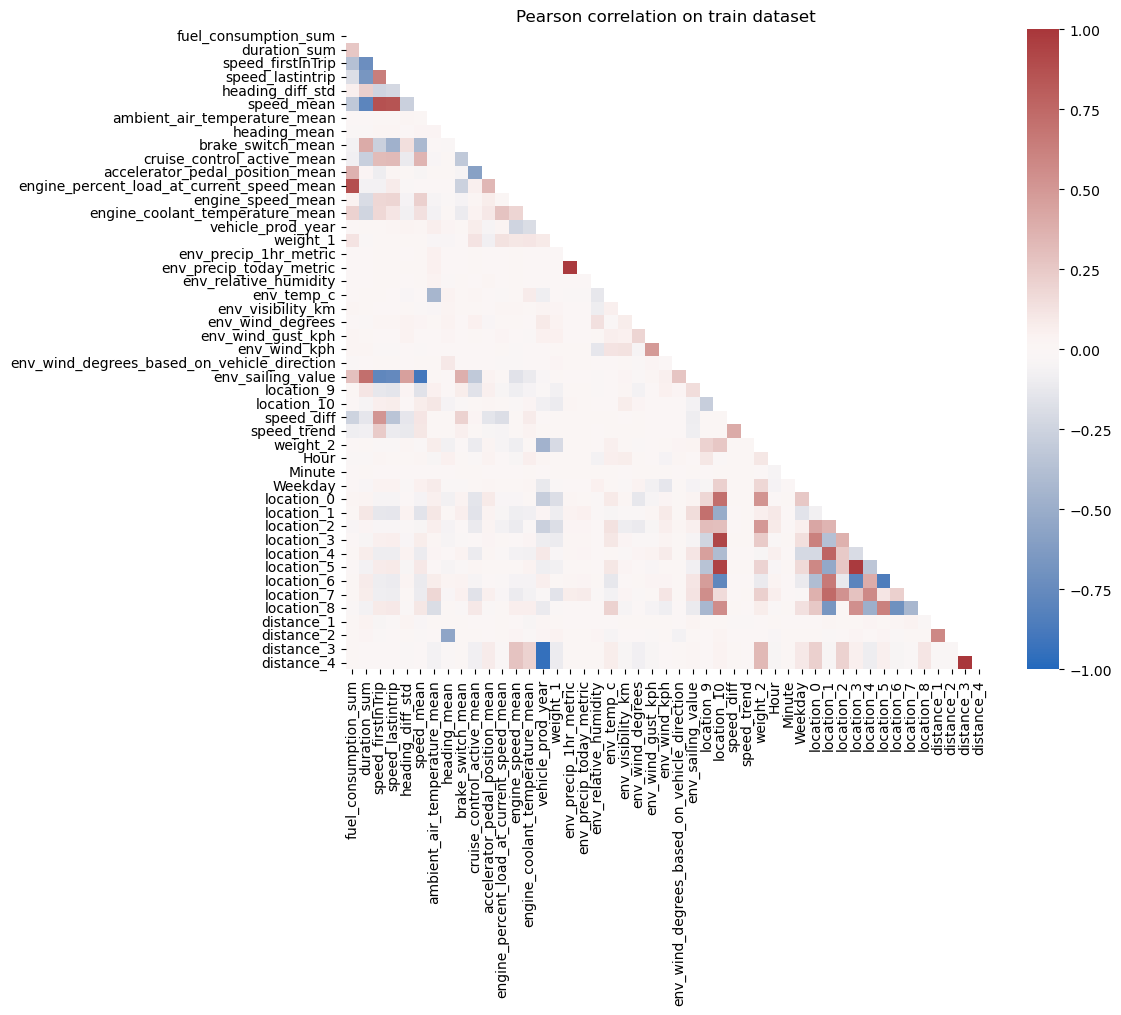

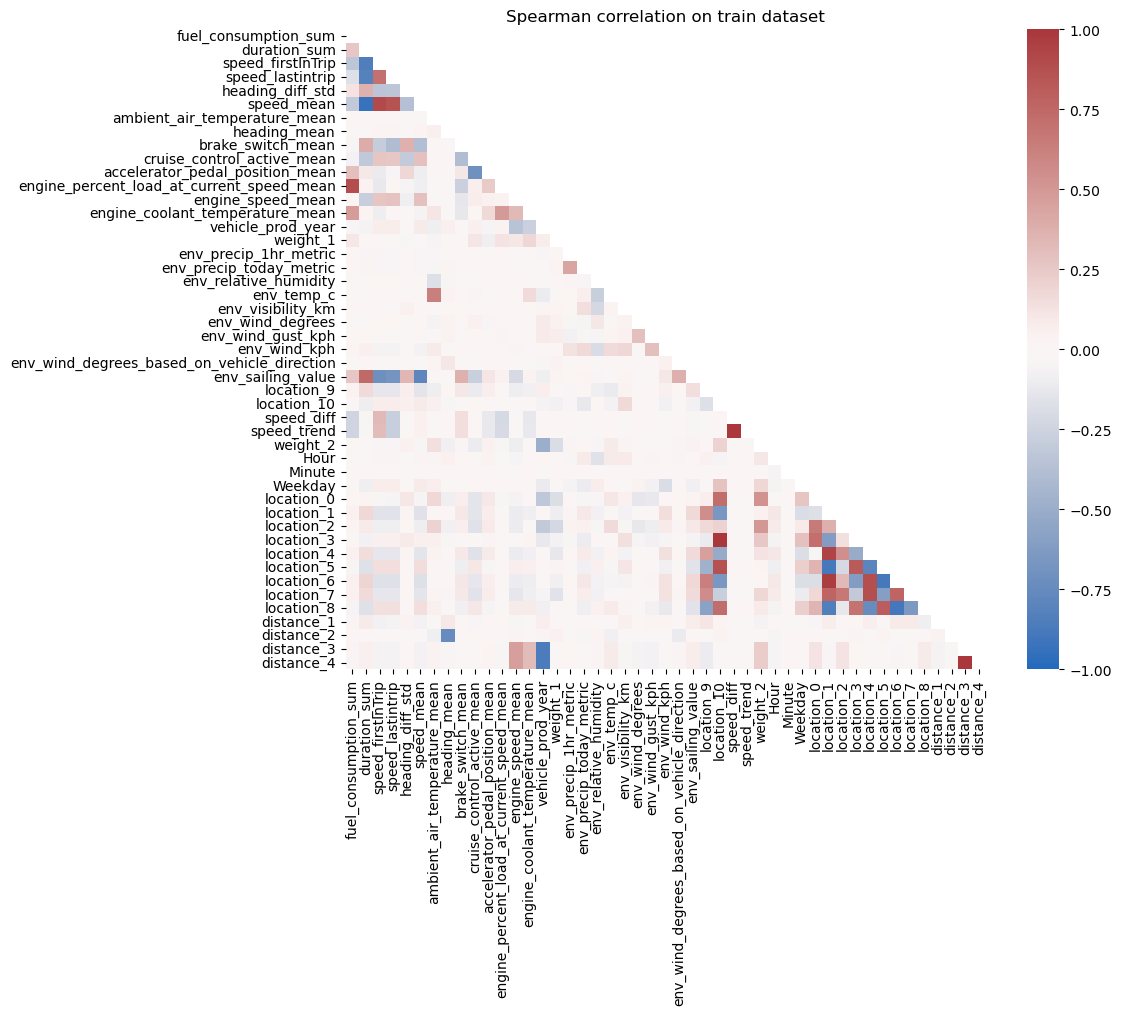

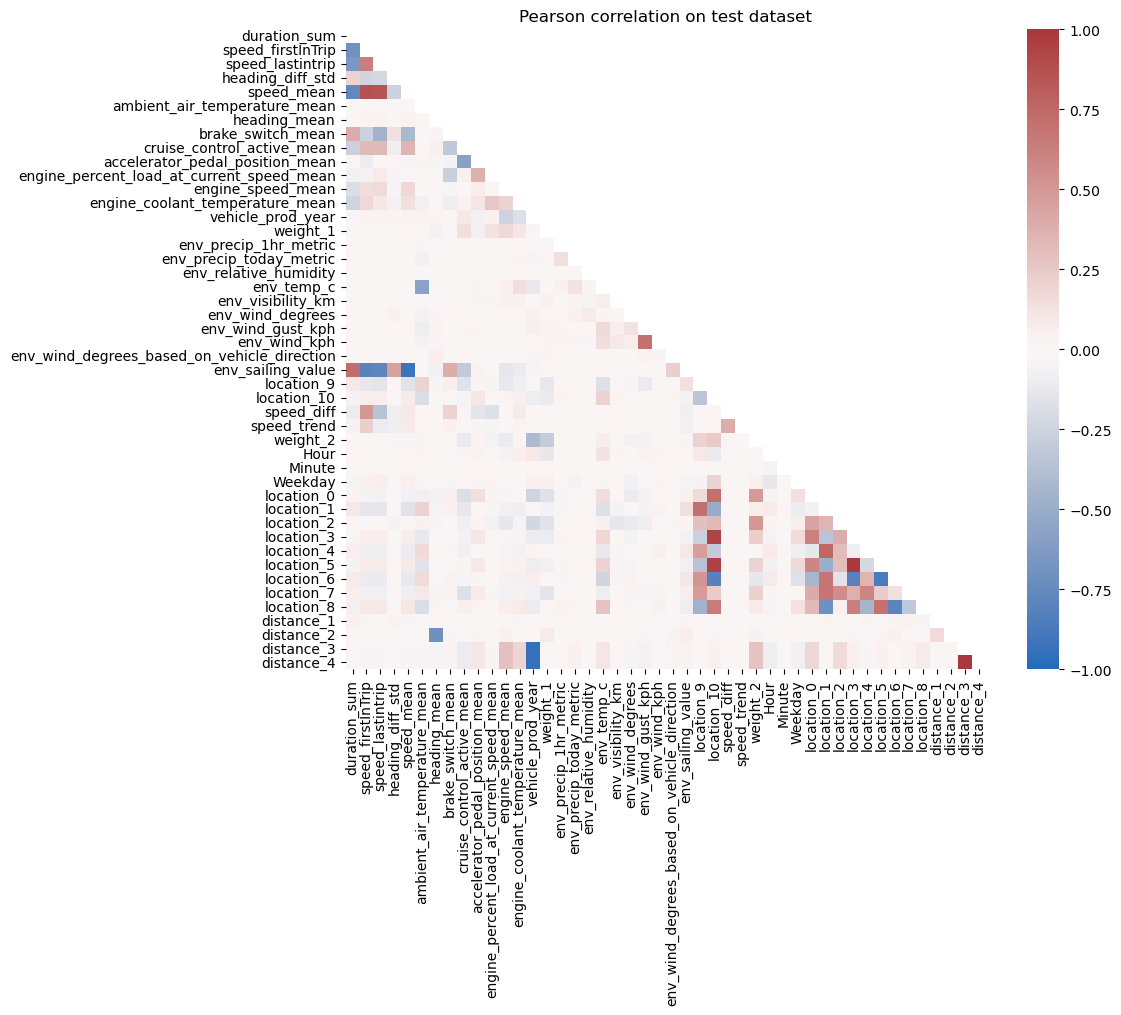

KeyboardInterrupt: 

In [18]:
pearson_heatmap(train_numerical, df_name="train", savepath='visualize/train_pearson_heatmap.png', annot=False)
spearman_heatmap(train_numerical, df_name="train", savepath='visualize/train_spearman_heatmap.png', annot=False)

pearson_heatmap(test_numerical, df_name="test", savepath='visualize/test_pearson_heatmap.png', annot=False)
spearman_heatmap(test_numerical, df_name="test", savepath='visualize/test_spearman_heatmap.png', annot=False)

/tmp/ipykernel_179213/1910154839.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_numerical.drop(columns=['fuel_consumption_sum'], inplace=True)


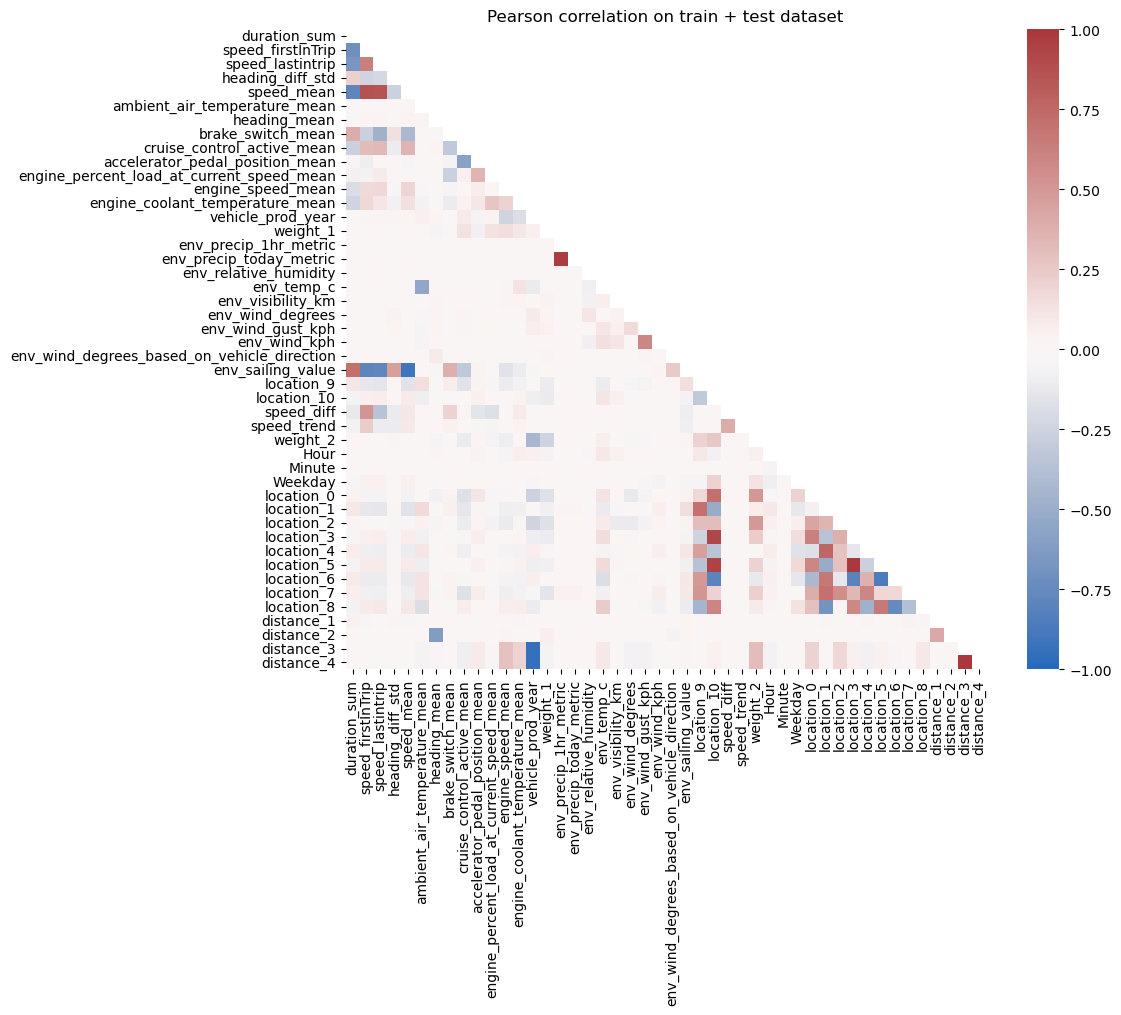

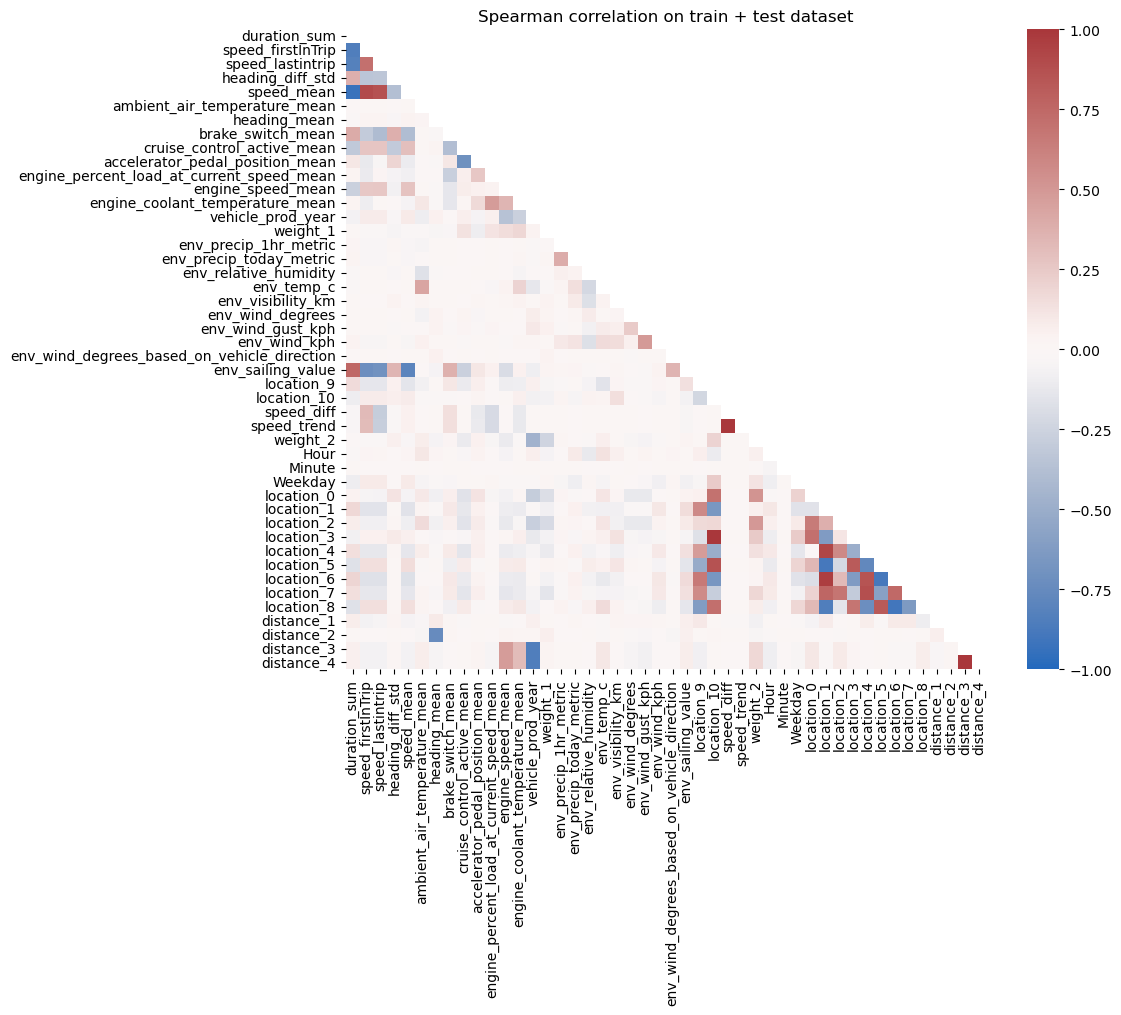

,duration_sum,speed_firstInTrip,speed_lastintrip,heading_diff_std,speed_mean,ambient_air_temperature_mean,heading_mean,brake_switch_mean,cruise_control_active_mean,accelerator_pedal_position_mean,...,location_3,location_4,location_5,location_6,location_7,location_8,distance_1,distance_2,distance_3,distance_4
duration_sum,1.000000,-0.846626,-0.824990,0.375291,-0.935595,-0.008773,-0.030458,0.402350,-0.316216,0.108272,...,-0.072716,0.143451,-0.167171,0.191399,0.146119,-0.165921,0.074654,0.006861,0.061396,0.061397
speed_firstInTrip,-0.846626,1.000000,0.710000,-0.340700,0.900068,0.004871,0.038443,-0.299234,0.271581,-0.123661,...,0.054201,-0.127938,0.144641,-0.166859,-0.128288,0.140946,-0.063755,-0.010478,-0.063748,-0.063749
speed_lastintrip,-0.824990,0.710000,1.000000,-0.333814,0.868532,0.005949,0.035269,-0.404497,0.266467,-0.041927,...,0.053748,-0.127704,0.144919,-0.167048,-0.128641,0.140871,-0.047226,-0.010871,-0.065215,-0.065215
heading_diff_std,0.375291,-0.340700,-0.333814,1.000000,-0.380313,-0.008872,-0.031718,0.376173,-0.311708,0.193222,...,0.091446,0.023205,0.006499,0.003898,0.010359,0.018317,0.034924,0.006302,0.020372,0.020373
speed_mean,-0.935595,0.900068,0.868532,-0.380313,1.000000,0.003479,0.040079,-0.391078,0.299434,-0.106500,...,0.056068,-0.135495,0.153075,-0.176218,-0.135076,0.148329,-0.057996,-0.009522,-0.068384,-0.068385
ambient_air_temperature_mean,-0.008773,0.004871,0.005949,-0.008872,0.003479,1.000000,0.024911,0.002401,0.010251,-0.010301,...,-0.008443,0.075378,-0.027377,-0.004288,0.036084,0.037347,-0.032514,-0.041119,0.076059,0.076059
heading_mean,-0.030458,0.038443,0.035269,-0.031718,0.040079,0.024911,1.000000,-0.029453,0.033299,-0.029542,...,-0.033865,-0.030277,0.009116,-0.014968,-0.035266,-0.001274,0.092305,-0.745012,-0.048821,-0.048821
brake_switch_mean,0.402350,-0.299234,-0.404497,0.376173,-0.391078,0.002401,-0.029453,1.000000,-0.390232,0.101864,...,-0.001510,0.090636,-0.091914,0.097448,0.090721,-0.079066,0.020717,0.021180,-0.002011,-0.002010
cruise_control_active_mean,-0.316216,0.271581,0.266467,-0.311708,0.299434,0.010251,0.033299,-0.390232,1.000000,-0.709177,...,-0.037996,-0.147714,0.080883,-0.115438,-0.142739,0.087437,-0.027597,-0.003972,0.000655,0.000655
accelerator_pedal_position_mean,0.108272,-0.123661,-0.041927,0.193222,-0.106500,-0.010301,-0.029542,0.101864,-0.709177,1.000000,...,0.062102,0.068759,-0.015708,0.039201,0.064689,-0.026329,0.003588,0.006453,0.035286,0.035286


In [ ]:
# train + test heatmaps
train_numerical.drop(columns=['fuel_consumption_sum'], inplace=True)
pearson_heatmap(pd.concat([train_numerical, test_numerical]), df_name="train + test", savepath='visualize/train_test_pearson_heatmap.png', annot=False)
spearman_heatmap(pd.concat([train_numerical, test_numerical]), df_name="train + test", savepath='visualize/train_test_spearman_heatmap.png', annot=False)